# Inverse Redshift Incompleteness Scenario - Photo-z Code

Natalia Stylianou (U. Leicester), with Alex Malz (GCCL@RUB) & Peter Hatfield (U. Oxford)

### Setup:
Installations:

In [ ]:
!pip install --target=$nb_path pzflow
!pip install git+https://github.com/LSSTDESC/RAIL.git#egg=rail[Full]
!git clone https://github.com/COINtoolbox/photoz_catalogues.git 

!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super
!pip install latex

In [ ]:
# CDETOOLS METRICS
!pip install cde-diagnostics
!pip install cdetools
!pip install corner
!pip install FlexCode
!pip install pzflow
!pip install sklearn
!pip install xgboost==0.90

!pip install git+https://github.com/LSSTDESC/qp.git#egg=qp[Full]

Prepare paths for local GPz module:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Coding')
import GPz

Imports

In [ ]:
import pylab as pb
from pzflow.examples import get_example_flow
from rail.creation import Creator, engines
from rail.creation.degradation import InvRedshiftIncompleteness, LineConfusion
import numpy as np
from numpy import *

import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
import csv
from scipy.stats import gaussian_kde
from matplotlib.gridspec import GridSpec

from cdetools import cde_loss, cdf_coverage, hpd_coverage
from scipy.stats import norm
import scipy.stats as sps
import qp

Generate mock redshifts, photometry, and posterior PDFs and degrade these data making an imperfect training set with the Inverse Redshift Incopleteness Degrader:

see [RAIL.creation degradation demo](https://github.com/LSSTDESC/RAIL/blob/master/examples/creation/degradation-demo.ipynb)

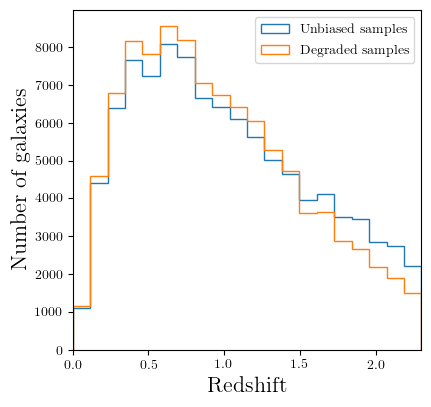

We rejected 7 columns in total


In [ ]:
z_max = 2.3
z_min = 0
y_grid = np.arange(z_min, z_max, 0.05)

flow = engines.FlowEngine(get_example_flow())
creator = Creator(flow)
degraded_creator = Creator(flow, degrader=InvRedshiftIncompleteness(1.38))

samples = creator.sample(100000, include_pdf=True, pz_grid = y_grid)
samples = samples[samples['redshift'] < 2.3]

degraded_samples = degraded_creator.sample(100000, pz_grid = y_grid)
degraded_samples = degraded_samples[degraded_samples['redshift'] < 2.3]

grid = y_grid
posteriors_test = samples['pz_pdf']
samples = samples[['redshift', 'u', 'g', 'r', 'i', 'z', 'y']]

fig, ax = plt.subplots(figsize=(4.5,4.5), dpi=100)
ax.hist(samples['redshift'], bins=20, range=(0,2.3), histtype='step', label="Unbiased samples")
ax.hist(degraded_samples['redshift'], bins=20, range=(0,2.3), histtype='step', label="Degraded samples")
ax.legend()
ax.set(xlabel="Redshift", ylabel="Number of galaxies", xlim=(0,2.3))
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_degradation.pdf", dpi=300, bbox_inches = "tight")

plt.show()

np.savetxt('/content/drive/MyDrive/Coding/Data/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot_1.38_samples.csv',samples, delimiter=',')
combined_pdfs=np.genfromtxt('/content/drive/MyDrive/Coding/Data/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot_1.38_samples.csv', delimiter=',')

np.savetxt('/content/drive/MyDrive/Coding/Data/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot_1.38_degraded_samples.csv',degraded_samples, delimiter=',')
combined_pdfs=np.genfromtxt('/content/drive/MyDrive/Coding/Data/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot_1.38_degraded_samples.csv', delimiter=',')

degraded_samples.shape == samples.shape


# Apply the Kolmogorov-Smirnov Test
#from scipy import stats
#p_value = 0.05
#rejected = 0
#for col in samples:
 #   test = stats.ks_2samp(samples[col], degraded_samples[col])
 #  if test[1] < p_value:
         rejected += 1
#print("We rejected",rejected,"columns in total")


samples.attrs['pz_grid']
true_grid = samples.attrs['pz_grid']

### Run NF (degraded and non-degraded) data through GPz to estimate Photo-z Point Estimates and Posterior PDFs

In [ ]:
########### Model options ###############

method = 'VC'               # select method, options = GL, VL, GD, VD, GC and VC [required]
                            #
m = 50                      # number of basis functions to use [required]
                            #
joint = True                # jointly learn a prior linear mean function [default=true]
                            #
heteroscedastic = True      # learn a heteroscedastic noise process, set to false interested only in point estimates
                            #
csl_method = 'normal'       # cost-sensitive learning option: [default='normal']
                            #       'balanced':     to weigh rare samples more heavly during train
                            #       'normalized':   assigns an error cost for each sample = 1/(z+1)
                            #       'normal':       no weights assigned, all samples are equally important
                            #
binWidth = 0.1              # the width of the bin for 'balanced' cost-sensitive learning [default=range(z_spec)/100]

decorrelate = True          # preprocess the data using PCA [default=False]

########### Training options ###########

dataPath_samples = '/content/drive/MyDrive/Coding/Data/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot_1.38_samples.csv'    # path to the data set, has to be in the following format m_1,m_2,..,m_k,e_1,e_2,...,e_k,z_spec
                                        # where m_i is the i-th magnitude, e_i is its associated uncertainty and z_spec is the spectroscopic redshift
                                        # [required]
dataPath_degraded_samples = '/content/drive/MyDrive/Coding/Data/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot_1.38_degraded_samples.csv'


maxIter = 500             # maximum number of iterations [default=200]
maxAttempts = 50              # maximum iterations to attempt if there is no progress on the validation set [default=infinity]
trainSplit = 0.2               # percentage of data to use for training
validSplit = 0.2               # percentage of data to use for validation
testSplit  = 0.6               # percentage of data to use for testing


In [ ]:
########### Start of script ###########

# Load samples
# read data from file
data = loadtxt(open(dataPath_samples,"rb"),delimiter=",")

X_samples = data[:, 1:6]
n,d = X_samples.shape
Y_samples = data[:, 0].reshape(n, 1)

filters = d/2

# log the uncertainties of the magnitudes, any additional preprocessing should be placed here
X_samples[:, int(filters):] = log(X_samples[:, int(filters):])


# sample training, validation and testing sets from the data
training,validation,testing = GPz.sample(n,trainSplit,validSplit,testSplit)

# you can also select the size of each sample
# training,validation,testing = GPz.sample(n,10000,10000,10000)

# get the weights for cost-sensitive learning
omega = GPz.getOmega(Y_samples, method=csl_method)


In [ ]:
# Load degraded_samples
# read data from file
data_2 = loadtxt(open(dataPath_degraded_samples,"rb"),delimiter=",")

X_degraded_samples = data_2[:, 1:6]
n,d = X_degraded_samples.shape
Y_degraded_samples = data_2[:, 0].reshape(n, 1)

filters = d/2

# log the uncertainties of the magnitudes, any additional preprocessing should be placed here
X_degraded_samples[:, int(filters):] = log(X_degraded_samples[:, int(filters):])



# sample training, validation and testing sets from the data
training_d,validation_d,testing_d = GPz.sample(n,trainSplit,validSplit,testSplit)

# you can also select the size of each sample
# training,validation,testing = GPz.sample(n,10000,10000,10000)

# get the weights for cost-sensitive learning
omega_d = GPz.getOmega(Y_degraded_samples, method=csl_method)


In [ ]:
# initialize the initial model
model_samples = GPz.GP(m,method=method,joint=joint,heteroscedastic=heteroscedastic,decorrelate=decorrelate)

# train the model
model_samples.train(X_samples.copy(), Y_samples.copy(), omega=omega, training=training, validation=validation, maxIter=maxIter, maxAttempts=maxAttempts)

########### NOTE ###########
# you can train the model gain, eve using different data, by executing:
# model.train(model,X,Y,options)

# use the model to generate predictions for the test set
mu_samples,variance_samples,modelV_samples,noiseV_samples,_ = model_samples.predict(X_samples[testing,:].copy())
sigma_samples = variance_samples**0.5



# initialize the initial model
model_degraded_samples = GPz.GP(m,method=method,joint=joint,heteroscedastic=heteroscedastic,decorrelate=decorrelate)

# train the model
model_degraded_samples.train(X_degraded_samples.copy(), Y_degraded_samples.copy(), omega=omega_d, training=training_d, validation=validation_d, maxIter=maxIter, maxAttempts=maxAttempts)

########### NOTE ###########
# you can train the model gain, eve using different data, by executing:
# model.train(model,X,Y,options)

# use the model to generate predictions for the test set
mu_degraded_samples,variance_degraded_samples,modelV_degraded_samples,noiseV_degraded_samples,_ = model_degraded_samples.predict(X_samples[testing,:].copy())
sigma_degraded_samples = variance_degraded_samples**0.5






########### Display Results ###########

# compute metrics   (compared to samples - true redshifts)
rmse_samples = sqrt(GPz.metrics(Y_samples[testing],mu_samples,variance_samples,lambda y,mu,sigma: (y-mu)**2))
mll_samples  = GPz.metrics(Y_samples[testing],mu_samples,variance_samples,lambda y,mu,sigma: -0.5*(y-mu)**2/sigma-0.5*log(sigma)-0.5*log(2*pi))
fr15_samples = GPz.metrics(Y_samples[testing],mu_samples,variance_samples,lambda y,mu,sigma: 100.0*(abs(y-mu)/(y+1.0)<0.15))
fr05_samples = GPz.metrics(Y_samples[testing],mu_samples,variance_samples,lambda y,mu,sigma: 100.0*(abs(y-mu)/(y+1.0)<0.05))
bias_samples = GPz.metrics(Y_samples[testing],mu_samples,variance_samples,lambda y,mu,sigma: y-mu)



# compute metrics   (compared to samples - true redshifts)
rmse_degraded_samples = sqrt(GPz.metrics(Y_samples[testing],mu_degraded_samples,variance_degraded_samples,lambda y,mu,sigma: (y-mu)**2))
mll_degraded_samples  = GPz.metrics(Y_samples[testing],mu_degraded_samples,variance_degraded_samples,lambda y,mu,sigma: -0.5*(y-mu)**2/sigma-0.5*log(sigma)-0.5*log(2*pi))
fr15_degraded_samples = GPz.metrics(Y_samples[testing],mu_degraded_samples,variance_degraded_samples,lambda y,mu,sigma: 100.0*(abs(y-mu)/(y+1.0)<0.15))
fr05_degraded_samples = GPz.metrics(Y_samples[testing],mu_degraded_samples,variance_degraded_samples,lambda y,mu,sigma: 100.0*(abs(y-mu)/(y+1.0)<0.05))
bias_degraded_samples = GPz.metrics(Y_samples[testing],mu_degraded_samples,variance_degraded_samples,lambda y,mu,sigma: y-mu)


# print metrics for the entire data
print(('{0:4s}\t\t\t{1:3s}\t\t\t{2:6s}\t\t\t{3:6s}\t\t\t{4:4s}'.format('RMSE', ' MLL', ' FR15', ' FR05', ' BIAS')))
print(('{0:1.7e}\t{1: 1.7e}\t{2: 1.7e}\t{3: 1.7e}\t{4: 1.7e}'.format(rmse_samples[-1], mll_samples[-1], fr15_samples[-1],fr05_samples[-1],bias_samples[-1])))
print(('{0:1.7e}\t{1: 1.7e}\t{2: 1.7e}\t{3: 1.7e}\t{4: 1.7e}'.format(rmse_degraded_samples[-1], mll_degraded_samples[-1], fr15_degraded_samples[-1],fr05_degraded_samples[-1],bias_degraded_samples[-1])))


## Plots

Figure 1: plot of Photometric vs Spectrosopic Redshifts, coloured by Uncertainty:

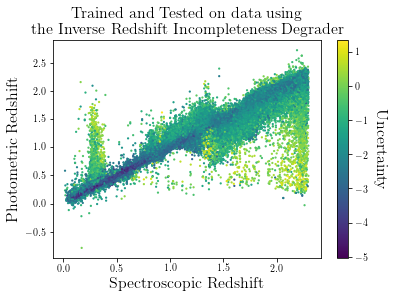

In [ ]:
# plot scatter plots for density and uncertainty
f = plt.figure(1)
plt.scatter(Y_samples[testing,:],mu_samples,s=5, c=np.log10(squeeze(variance_samples)), edgecolor=['none'])
plt.scatter(Y_samples[testing,:],mu_degraded_samples,s=5, c=np.log10(squeeze(variance_degraded_samples)), edgecolor=['none'])
cbar = plt.colorbar()
cbar.set_label('Uncertainty', rotation=270, labelpad=20)
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Photometric Redshift')
plt.title('Trained and Tested on data using \n the Inverse Redshift Incompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_photoz_1.pdf", dpi=300, bbox_inches = "tight")

Figure 2: plot of Photometric vs Spectrosopic Redshifts, coloured by Density:

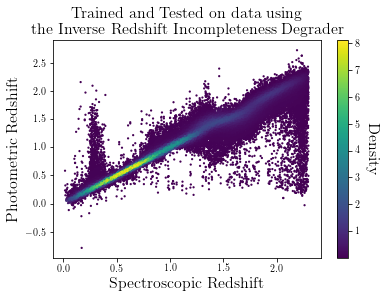

In [ ]:
f = plt.figure(2)
xy_s = hstack([Y_samples[testing,:],mu_samples]).T
xy_ds = hstack([Y_samples[testing,:],mu_degraded_samples]).T

z_s = gaussian_kde(xy_s)(xy_s)
z_ds = gaussian_kde(xy_ds)(xy_ds)
plt.scatter(Y_samples[testing,:],mu_samples,s=5, c=z_s, edgecolor=['none'])
plt.scatter(Y_samples[testing,:],mu_degraded_samples,s=5, c=z_ds, edgecolor=['none'])
cbar = plt.colorbar()
cbar.set_label('Density', rotation=270, labelpad=20)
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Photometric Redshift')
plt.title('Trained and Tested on data using \n the Inverse Redshift Incompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_photoz_2.pdf", dpi=300, bbox_inches = "tight")

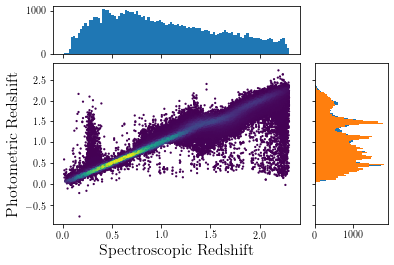

In [ ]:
# marginal histograms of spectroscopic redshifts and photometric redshift estimates
f = plt.figure(2.1)

gs = GridSpec(4,4)

ax_joint = f.add_subplot(gs[1:4,0:3])
ax_marg_x = f.add_subplot(gs[0,0:3])
ax_marg_y = f.add_subplot(gs[1:4,3])

xy_s = hstack([Y_samples[testing,:],mu_samples]).T
xy_ds = hstack([Y_samples[testing,:],mu_degraded_samples]).T
z_s = gaussian_kde(xy_s)(xy_s)
z_ds = gaussian_kde(xy_ds)(xy_ds)

#ax_joint.scatter(Y_samples[testing,:], mu_samples, s=5, c=z, edgecolor=['none'])
im = ax_joint.scatter(Y_samples[testing,:], mu_samples, s=5, c=z_s, cmap=plt.cm.viridis, edgecolor=['none'])
im = ax_joint.scatter(Y_samples[testing,:], mu_degraded_samples, s=5, c=z_ds, cmap=plt.cm.viridis, edgecolor=['none'])
#f.colorbar(im, ax=ax_joint)

ax_marg_x.hist(Y_samples[testing,:], bins=100)
ax_marg_y.hist(mu_samples,orientation="horizontal", bins=100)
ax_marg_y.hist(mu_degraded_samples,orientation="horizontal", bins=100)

# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Spectroscopic Redshift')
ax_joint.set_ylabel('Photometric Redshift')

# Set labels on marginals
#ax_marg_y.set_xlabel('Marginal x label')
#ax_marg_x.set_ylabel('Marginal y label')

#ax_joint.set_title('2 iterations - Trained on Samples and Tested on Samples', loc='center')

pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_photoz_2.1.pdf", dpi=300, bbox_inches = "tight")

### Plots of Point Estimate Evaluation Metrics 
(evaluating metrics of estimated redshift information)

Figure 3: plot of RMSE against the Percentage of the Data:

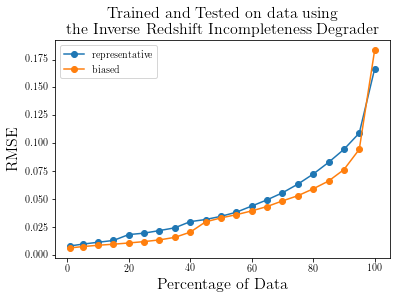

In [ ]:
# plot the change in metrics as functions of data percentage
x = array(list(range(0,20+1)))*5
x[0]=1

ind_s = x*len(rmse_samples) // 100
ind_ds = x*len(rmse_degraded_samples) // 100

f = plt.figure(3)
plt.plot(x,rmse_samples[ind_s-1],'o-', label="representative")
plt.plot(x,rmse_degraded_samples[ind_ds-1],'o-', label="biased")
plt.legend()
plt.xlabel('Percentage of Data')
plt.ylabel('RMSE')
plt.title('Trained and Tested on data using \n the Inverse Redshift Incompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_photoz_3_rmse.pdf", dpi=300, bbox_inches = "tight")

Figure 4: plot of MLL against the Percentage of the Data:

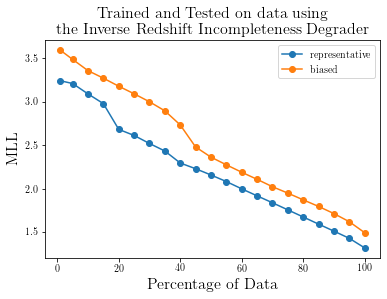

In [ ]:
f = plt.figure(4)
plt.plot(x,mll_samples[ind_s-1],'o-', label="representative")
plt.plot(x,mll_degraded_samples[ind_ds-1],'o-',  label="biased")
plt.legend(loc='upper right')
plt.xlabel('Percentage of Data')
plt.ylabel('MLL')
plt.title('Trained and Tested on data using \n the Inverse Redshift Incompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_photoz_4_mll.pdf", dpi=300, bbox_inches = "tight")

Figure 5: plot of FR15 against the Percentage of the Data:

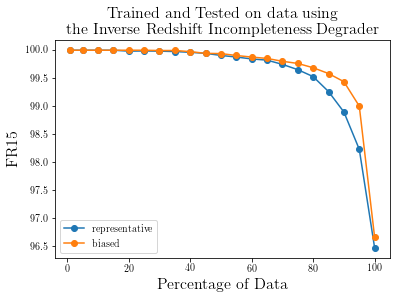

In [ ]:
f = plt.figure(5)
plt.plot(x,fr15_samples[ind_s-1],'o-', label="representative")
plt.plot(x,fr15_degraded_samples[ind_ds-1],'o-', label="biased")
plt.legend()
plt.xlabel('Percentage of Data')
plt.ylabel('FR15')
plt.title('Trained and Tested on data using \n the Inverse Redshift Incompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_photoz_5_fr15.pdf", dpi=300, bbox_inches = "tight")

Figure 6: plot of FR05 against the Percentage of the Data:

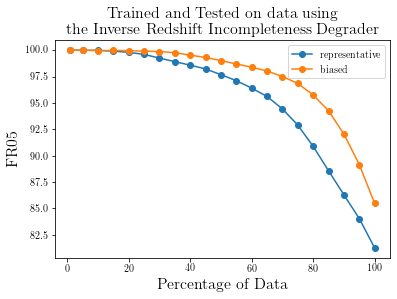

In [ ]:
f = plt.figure(6)
plt.plot(x,fr05_samples[ind_s-1],'o-', label="representative")
plt.plot(x,fr05_degraded_samples[ind_ds-1],'o-',  label="biased")
plt.legend()
plt.xlabel('Percentage of Data')
plt.ylabel('FR05')
plt.title('Trained and Tested on data using \n the Inverse Redshift Incompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_photoz_6_fr05.pdf", dpi=300, bbox_inches = "tight")

Figure 7: plot of BIAS against the Percentage of the Data:

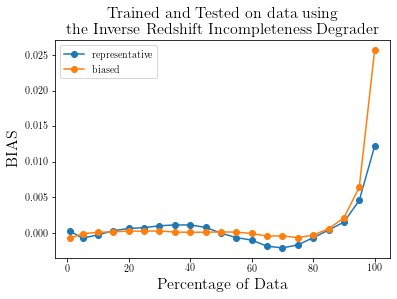

In [ ]:
f = plt.figure(7)
plt.plot(x,bias_samples[ind_s-1],'o-', label="representative")
plt.plot(x,bias_degraded_samples[ind_ds-1],'o-', label="biased")
plt.legend()
plt.xlabel('Percentage of Data')
plt.ylabel('BIAS')
plt.title('Trained and Tested on data using \n the Inverse Redshift Incompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_photoz_7_bias.pdf", dpi=300, bbox_inches = "tight")

Plot of the RMSE, FR15 & BIAS against the Percentage of Data:

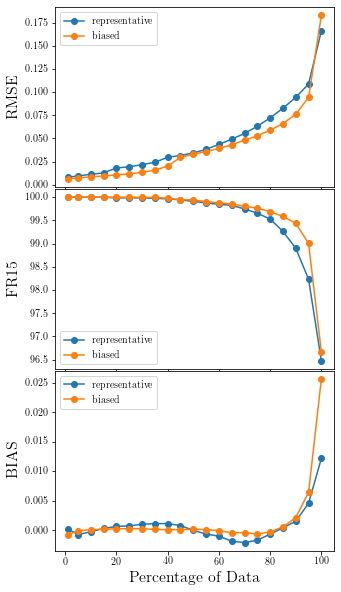

In [ ]:
#RMSE, FR15 & BIAS PLOTS TOGETHER:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(5, 10))

#ax1.set_title('Trained and Tested on data using \n the Emission Line Confusion Degrader')
x = array(list(range(0,20+1)))*5
x[0]=1

ind_s = x*len(rmse_samples) // 100
ind_ds = x*len(rmse_degraded_samples) // 100

ax1.plot(x,rmse_samples[ind_s-1],'o-', label="representative")
ax1.plot(x,rmse_degraded_samples[ind_ds-1],'o-', label="biased")
ax1.legend()
ax1.set_ylabel('RMSE')

ax2.plot(x,fr15_samples[ind_s-1],'o-', label="representative")
ax2.plot(x,fr15_degraded_samples[ind_ds-1],'o-', label="biased")
ax2.legend()
ax2.set_ylabel('FR15')

ax3.plot(x,bias_samples[ind_s-1],'o-', label="representative")
ax3.plot(x,bias_degraded_samples[ind_ds-1],'o-', label="biased")
ax3.legend()
ax3.set_ylabel('BIAS')

ax3.set_xlabel('Percentage of Data')

plt.subplots_adjust(hspace=.01)

pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_RMSE_FR15_BIAS.pdf", dpi=300, bbox_inches = "tight")

### Plots of Evaluation Metrics against the Spectroscopic Redshift

Figure 8: plot of the Bias against the Spectroscopic Redshift:

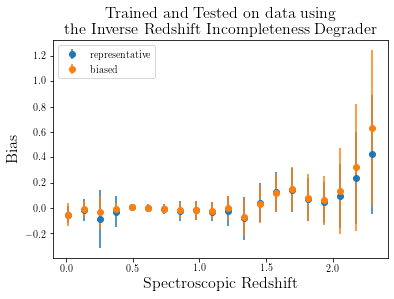

In [ ]:
# plot mean and standard deviation of different scores as functions of spectroscopic redshift using 20 bins
f = plt.figure(8)
centers_s,means_s,stds_s = GPz.bin(Y_samples[testing],Y_samples[testing]-mu_samples,20)
centers_ds,means_ds,stds_ds = GPz.bin(Y_samples[testing],Y_samples[testing]-mu_degraded_samples,20)
plt.errorbar(centers_s,means_s,stds_s,fmt='o', label= 'representative')
plt.errorbar(centers_ds,means_ds,stds_ds,fmt='o', label= 'biased')
plt.legend(loc='upper left')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Bias')
plt.title('Trained and Tested on data using \n the Inverse Redshift Incompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_photoz_8_bias.pdf", dpi=300, bbox_inches = "tight")

Figure 9: plot of the Model Uncertainty against the Spectroscopic Redshift:

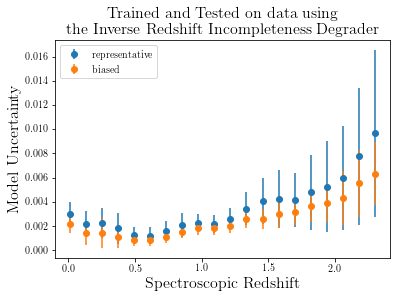

In [ ]:
f = plt.figure(9)
centers_s,means_s,stds_s = GPz.bin(Y_samples[testing],sqrt(modelV_samples),20)
centers_ds,means_ds,stds_ds = GPz.bin(Y_samples[testing],sqrt(modelV_degraded_samples),20)
plt.errorbar(centers_s,means_s,stds_s,fmt='o', label= 'representative')
plt.errorbar(centers_ds,means_ds,stds_ds,fmt='o', label= 'biased')
plt.legend(loc='upper left')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Model Uncertainty')
plt.title('Trained and Tested on data using \n the Inverse Redshift Incompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_photoz_9_modelV.pdf", dpi=300, bbox_inches = "tight")

Figure 10: plot of the Noise Uncertainty against the Spectroscopic Redshift:

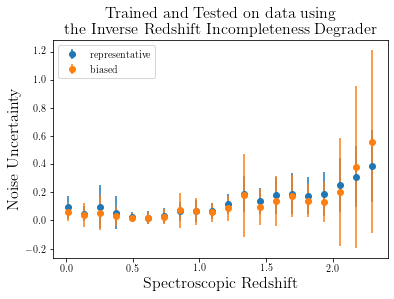

In [ ]:
f = plt.figure(10)
centers_s,means_s,stds_s = GPz.bin(Y_samples[testing],sqrt(noiseV_samples),20)
centers_ds,means_ds,stds_ds = GPz.bin(Y_samples[testing],sqrt(noiseV_degraded_samples),20)
plt.errorbar(centers_s,means_s,stds_s,fmt='o', label= 'representative')
plt.errorbar(centers_ds,means_ds,stds_ds,fmt='o', label= 'biased')
plt.legend(loc='upper left')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Noise Uncertainty')
plt.title('Trained and Tested on data using \n the Inverse Redshift Incompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_photoz_10_noiseV.pdf", dpi=300, bbox_inches = "tight")

Figure 11: plot of the Bias against the R-Band Magnitude:

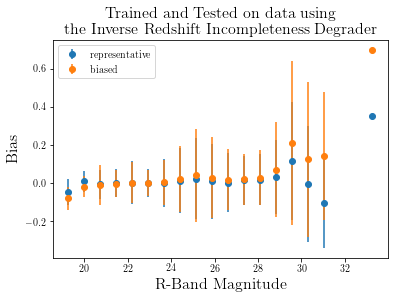

In [ ]:
# plot of bias as a function of magnitude 
f = plt.figure(11)
no = len(data)
X_s = data[:, 2].reshape(no,1)
centers_s,means_s,stds_s = GPz.bin(X_s[testing,:], Y_samples[testing,:] - mu_samples, 20)
centers_ds,means_ds,stds_ds = GPz.bin(X_s[testing,:], Y_samples[testing,:] - mu_degraded_samples, 20)
plt.errorbar(centers_s,means_s,stds_s,fmt='o', label= 'representative')
plt.errorbar(centers_ds,means_ds,stds_ds,fmt='o', label= 'biased')
plt.legend()
plt.xlabel('R-Band Magnitude')
plt.ylabel('Bias')
plt.title('Trained and Tested on data using \n the Inverse Redshift Incompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_photoz_11.pdf", dpi=300, bbox_inches = "tight")

Figure 12: plot of the Photometric Redshift Biased vs Representative Data:

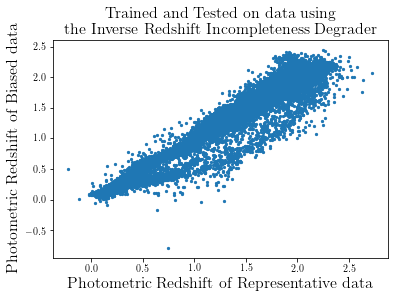

In [ ]:
f = plt.figure(12)
plt.scatter(mu_samples, mu_degraded_samples, s=5)
plt.xlabel('Photometric Redshift of Representative data')
plt.ylabel('Photometric Redshift of Biased data')
plt.title('Trained and Tested on data using \n the Inverse Redshift Incompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_photoz_12.pdf", dpi=300, bbox_inches = "tight")

Figure 13: plot of the Average RMSE against the Pivot Redshift:

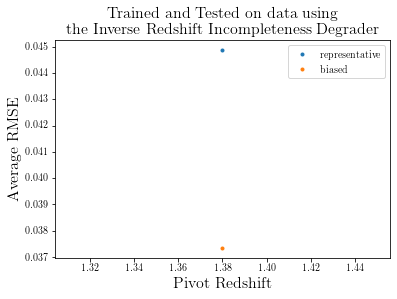

In [ ]:
z_pivot = 1.38  #depended on the z_pivot parameter in question
avg_rmse_samples = sum(rmse_samples) / len(rmse_samples)
avg_rmse_degraded_samples = sum(rmse_degraded_samples) / len(rmse_degraded_samples)

f = plt.figure(13)
plt.plot(z_pivot, avg_rmse_samples,'.', label="representative")
plt.plot(z_pivot, avg_rmse_degraded_samples,'.', label="biased")

plt.legend()
plt.xlabel('Pivot Redshift')
plt.ylabel('Average RMSE')
plt.title('Trained and Tested on data using \n the Inverse Redshift Incompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_photoz_13_aver_rmse_vs_z_pivot.pdf", dpi=300, bbox_inches = "tight")

Figure 14: plot of 10 (random) RMSE values in terms of the Pivot Redshift:

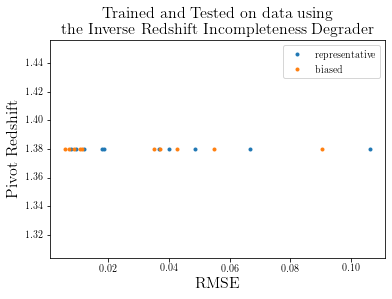

In [ ]:
idx = np.random.choice(np.arange(len(rmse_samples)), 10, replace=False)
rmse_samples_10 = rmse_samples[idx]
rmse_degraded_samples_10 = rmse_degraded_samples[idx]

z_pivot_no = 1.38  #depended on the z_pivot parameter in question
z_pivot = np.tile(z_pivot_no, 10)

f = plt.figure(14)
plt.plot(rmse_samples_10, z_pivot,'.', label="representative")
plt.plot(rmse_degraded_samples_10, z_pivot, '.', label="biased")
plt.legend()
plt.xlabel('RMSE')
plt.ylabel('Pivot Redshift')
plt.title('Trained and Tested on data using \n the Inverse Redshift Incompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_photoz_14_rmse_vs_z_pivot.pdf", dpi=300, bbox_inches = "tight")

In [ ]:
# save output as a comma seperated values (mean,sigma,model_variance,noise_varian
#savetxt(method+'_'+str(m)+'_'+csl_method+'.csv', array([mu_samples,variance_samples,modelV_samples,noiseV_samples])[:,:,0].T, delimiter=',')

#savetxt(method+'_'+str(m)+'_'+csl_method+'_degraded.csv', array([mu_degraded_samples,variance_degraded_samples,modelV_degraded_samples,noiseV_degraded_samples])[:,:,0].T, delimiter=',')

In [ ]:
#[mu_samples,variance_samples,modelV_samples,noiseV_samples] = loadtxt(open(method+'_'+str(m)+'_'+csl_method+'.csv',"rb"),delimiter=",").T

#[mu_degraded_samples,variance_degraded_samples,modelV_degraded_samples,noiseV_degraded_samples] = loadtxt(open(method+'_'+str(m)+'_'+csl_method+'_degraded.csv',"rb"),delimiter=",").T

## Evaluating the performance of estimated photo- posterior PDFs
following [qtc2021 intro](https://github.com/aimalz/qtc2021/blob/interpret_metrics/intro.ipynb)
### Metrics of estimated photo- posteriors and true redshifts
Plot of the Probability Integral Transform (PIT):


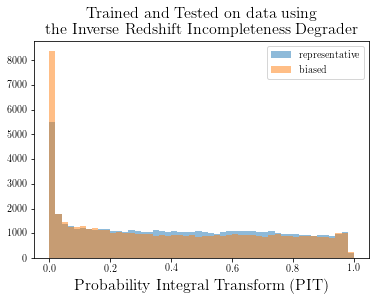

In [ ]:
#Creating a Normal Distribution
def normal_dist(y_grid , mu_samples , sigma_samples):
    prob_density = 1/((2*np.pi*sigma_samples**2)**(1/2)) * np.exp(-0.5*((y_grid-mu_samples)/sigma_samples)**2)
    return prob_density

cde_test = normal_dist(y_grid,mu_samples,sigma_samples)
cde_test_bias = normal_dist(y_grid, mu_degraded_samples, sigma_degraded_samples)

pit_values = cdf_coverage.cdf_coverage(cde_test, y_grid, Y_samples[testing])
pit_values_bias = cdf_coverage.cdf_coverage(cde_test_bias, y_grid, Y_samples[testing])

plt.hist(pit_values, alpha=0.5, bins=np.arange(0, 1+0.02, 0.02), label='representative', density=False)
plt.hist(pit_values_bias, alpha=0.5, bins=np.arange(0, 1+0.02, 0.02), label='biased',  density=False)

plt.legend()
plt.xlabel('Probability Integral Transform (PIT)')
plt.title('Trained and Tested on data using \n the Inverse Redshift Incompleteness Degrader')

pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_cde_PIT.pdf", dpi=300, bbox_inches = "tight")


Plots of the Low and High PIT Redshift Bias:

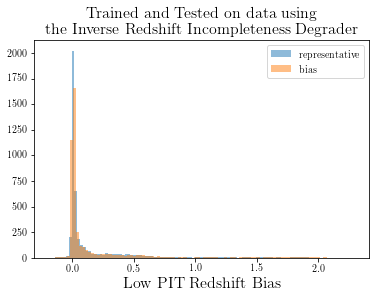

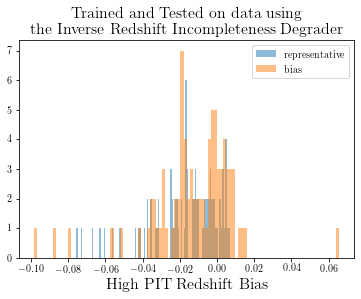

In [ ]:
# redshift bias against for the 0<PIT<0.01 and 0.99<PIT<1 subsamples
low_pit_mask = np.where(pit_values < 0.01)
low_pit_true_redshifts = Y_samples[testing][low_pit_mask]
low_pit_mu_samples = mu_samples[low_pit_mask]
low_pit_mu_degraded_samples = mu_degraded_samples[low_pit_mask]

low_pit_bias_s = low_pit_true_redshifts - low_pit_mu_samples
low_pit_bias_ds = low_pit_true_redshifts - low_pit_mu_degraded_samples

plt.hist(low_pit_bias_s, bins =100, alpha=0.5, label='representative')
plt.hist(low_pit_bias_ds, bins =100, alpha=0.5, label='bias')
plt.legend()
plt.xlabel('Low PIT Redshift Bias')
plt.title('Trained and Tested on data using \n the Inverse Redshift Incompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_Low_PIT_Redshift_Bias.pdf", dpi=300, bbox_inches = "tight")
plt.show()

high_pit_mask = np.where((pit_values < 1.) & (pit_values > 0.99))
high_pit_true_redshifts = Y_samples[testing][high_pit_mask]
high_pit_mu_samples = mu_samples[high_pit_mask]
high_pit_mu_degraded_samples = mu_degraded_samples[high_pit_mask]

high_pit_bias_s = high_pit_true_redshifts - high_pit_mu_samples
high_pit_bias_ds = high_pit_true_redshifts - high_pit_mu_degraded_samples

plt.hist(high_pit_bias_s, bins =100, alpha=0.5, label='representative')
plt.hist(high_pit_bias_ds, bins =100, alpha=0.5, label='bias')
plt.xlabel('High PIT Redshift Bias')
plt.legend()
plt.title('Trained and Tested on data using \n the Inverse Redshift Incompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_High_PIT_Redshift_Bias.pdf", dpi=300, bbox_inches = "tight")



Plot of the Low and Hight PIT Redhsift Bias Together:

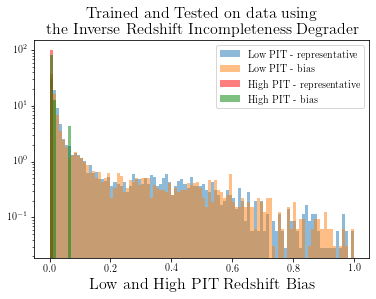

In [ ]:
# redshift bias against for the 0<PIT<0.01 and 0.99<PIT<1 subsamples - TOGETHER

plt.hist(low_pit_bias_s, bins = np.arange(0, 1+0.01, 0.01), alpha=0.5, label='Low PIT - representative', density= True)
plt.hist(low_pit_bias_ds, bins = np.arange(0, 1+0.01, 0.01), alpha=0.5, label='Low PIT - bias', density= True)
plt.hist(high_pit_bias_s, bins = np.arange(0, 1+0.01, 0.01), alpha=0.5, label='High PIT - representative', color = 'red', density= True)
plt.hist(high_pit_bias_ds, bins = np.arange(0, 1+0.01, 0.01), alpha=0.5, label='High PIT - bias', color = 'green', density= True)
plt.legend()
plt.semilogy()
plt.xlabel('Low and High PIT Redshift Bias')
plt.title('Trained and Tested on data using \n the Inverse Redshift Incompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_Low_and_High_PIT_Redshift_Bias.pdf", dpi=300, bbox_inches = "tight")


Plots of the Low and Hight PIT GPz-estimated Variance:

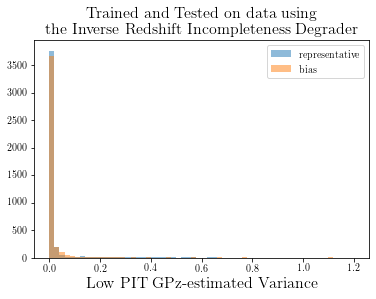

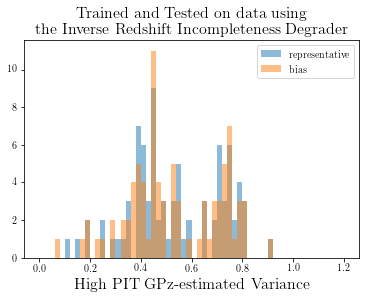

In [ ]:
# GPz variance against for the 0<PIT<0.01 and 0.99<PIT<1 subsamples

low_pit_mask = np.where(pit_values < 0.01)
low_pit_variance_samples = variance_samples[low_pit_mask]
low_pit_variance_degraded_samples = variance_degraded_samples[low_pit_mask]

high_pit_mask = np.where((pit_values < 1.) & (pit_values > 0.99))
high_pit_variance_samples = mu_samples[high_pit_mask]
high_pit_variance_degraded_samples = mu_degraded_samples[high_pit_mask]

plt.hist(low_pit_variance_samples, bins = np.arange(0, 1.2+0.02, 0.02), alpha=0.5, label='representative')
plt.hist(low_pit_variance_degraded_samples, bins = np.arange(0, 1.2+0.02, 0.02), alpha=0.5, label='bias')
plt.legend()
plt.xlabel('Low PIT GPz-estimated Variance')
plt.title('Trained and Tested on data using \n the Inverse Redshift Incompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_Low_PIT_Variance.pdf", dpi=300, bbox_inches = "tight")

plt.show()

plt.hist(high_pit_variance_samples, bins = np.arange(0, 1.2+0.02, 0.02), alpha=0.5, label='representative')
plt.hist(high_pit_variance_degraded_samples, bins = np.arange(0, 1.2+0.02, 0.02), alpha=0.5, label='bias')
plt.xlabel('High PIT GPz-estimated Variance')
plt.legend()
plt.title('Trained and Tested on data using \n the Inverse Redshift Incompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_High_PIT_Variance.pdf", dpi=300, bbox_inches = "tight")


Plot of the Low and Hight PIT GPz-estimated Variance Together:

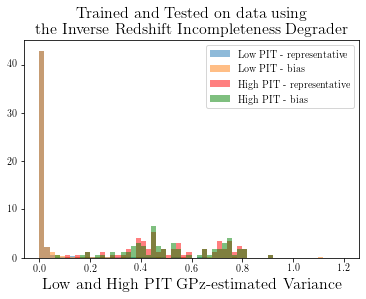

In [ ]:
# GPz variance against for the 0<PIT<0.01 and 0.99<PIT<1 subsamples - TOGETHER

plt.hist(low_pit_variance_samples, bins = np.arange(0, 1.2+0.02, 0.02), alpha=0.5, label='Low PIT - representative', density= True)
plt.hist(low_pit_variance_degraded_samples, bins = np.arange(0, 1.2+0.02, 0.02), alpha=0.5, label='Low PIT - bias', density= True)
plt.hist(high_pit_variance_samples, bins = np.arange(0, 1.2+0.02, 0.02), alpha=0.5, label='High PIT - representative', color = 'red', density= True)
plt.hist(high_pit_variance_degraded_samples, bins = np.arange(0, 1.2+0.02, 0.02), alpha=0.5, label='High PIT - bias', color = 'green', density= True)
plt.legend()
plt.xlabel('Low and High PIT GPz-estimated Variance')
plt.title('Trained and Tested on data using \n the Inverse Redshift Incompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_Low_and_High_PIT_Variance.pdf", dpi=300, bbox_inches = "tight")


Plot of the Highest Predictive Density (HPD):

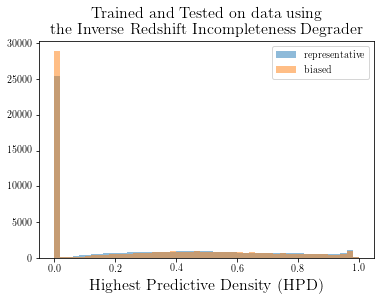

In [ ]:
hpd_cov = hpd_coverage.hpd_coverage(cde_test, y_grid, Y_samples[testing])
hpd_cov_bias = hpd_coverage.hpd_coverage(cde_test_bias, y_grid, Y_samples[testing])

plt.hist(hpd_cov, alpha=0.5, bins=np.arange(0, 1+0.02, 0.02), label='representative')
plt.hist(hpd_cov_bias, alpha=0.5, bins=np.arange(0, 1+0.02, 0.02), label='biased')
plt.legend()
plt.xlabel('Highest Predictive Density (HPD)')
plt.title('Trained and Tested on data using \n the Inverse Redshift Incompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_cde_HPD.pdf", dpi=300, bbox_inches = "tight")

The CDE loss:

In [ ]:
print(cde_loss.cde_loss(cde_test, y_grid, Y_samples[testing]))
print(cde_loss.cde_loss(cde_test_bias, y_grid, Y_samples[testing]))

(-5.824351610603453, 0.03701895430271489)
(-5.761895760310041, 0.05060516305621764)


### Comparison of estimated and true photo- posterior PDFs

In [ ]:
Q = qp.Ensemble(qp.interp, data=dict(xvals=y_grid.reshape(y_grid.shape[0]), yvals=cde_test))
Q_bias = qp.Ensemble(qp.interp, data=dict(xvals=y_grid.reshape(y_grid.shape[0]), yvals=cde_test_bias))
grid = true_grid
grid, approx_pdf_on_grid = Q.gridded(grid)
grid, approx_pdf_on_grid_bias = Q_bias.gridded(grid)

Plot of the Kullback Leibler Divergence (KLD):

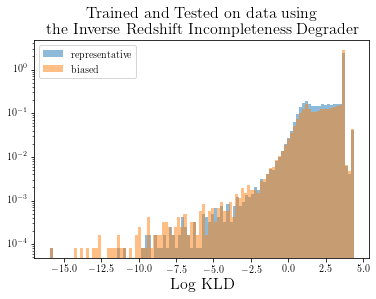

In [ ]:
KLDs = np.array([qp.metrics.quick_kld(p, q, dx=np.mean(grid[1:] - grid[:-1])) for p, q in zip(posteriors_test, approx_pdf_on_grid)])
KLDs_bias = np.array([qp.metrics.quick_kld(p, q, dx=np.mean(grid[1:] - grid[:-1])) for p, q in zip(posteriors_test, approx_pdf_on_grid_bias)])

plt.hist(np.log(KLDs), alpha=0.5, bins=100, label='representative', density=True)
plt.hist(np.log(KLDs_bias), alpha=0.5, bins=100, label='biased', density=True)
plt.xlabel('Log KLD')
plt.legend()
plt.semilogy()
plt.title('Trained and Tested on data using \n the Inverse Redshift Incompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_cde_Log_KLDs.pdf", dpi=300, bbox_inches = "tight")


Plot of the root-mean-square-error (RMSE):

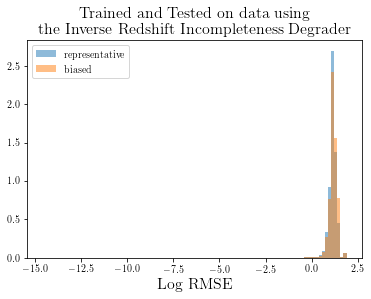

In [ ]:
granularity =  len(true_grid)
RMSEs = np.array([qp.metrics.quick_rmse(p, q, N=granularity) for p, q in zip(posteriors_test, approx_pdf_on_grid)])
RMSEs_bias = np.array([qp.metrics.quick_rmse(p, q, N=granularity) for p, q in zip(posteriors_test, approx_pdf_on_grid_bias)])

plt.hist(np.log(RMSEs), alpha=0.5, bins=100, label='representative', density=True)
plt.hist(np.log(RMSEs_bias), alpha=0.5, bins=100, label='biased', density=True)
plt.xlabel('Log RMSE')
plt.legend()
plt.title('Trained and Tested on data using \n the Inverse Redshift Incompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_cde_Log_RMSEs.pdf", dpi=300, bbox_inches = "tight")


### Visualising the Data - Plots:

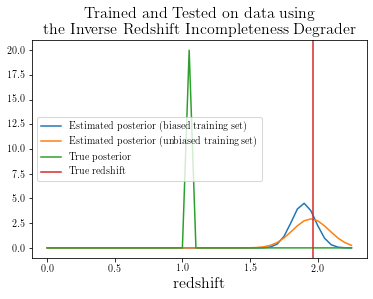

In [ ]:
chosen = 9
plt.plot(y_grid, cde_test_bias[chosen], label='Estimated posterior (biased training set)')
plt.plot(y_grid, cde_test[chosen], label='Estimated posterior (unbiased training set)')
plt.plot(grid, posteriors_test[chosen], label='True posterior')
plt.axvline(Y_samples[testing][chosen], 0, 1, c='C3', label='True redshift')
plt.legend()
plt.xlabel("redshift")
plt.title('Trained and Tested on data using \n the Inverse Redshift Incompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_cde_9_redshift.pdf", dpi=300, bbox_inches = "tight")
plt.show()


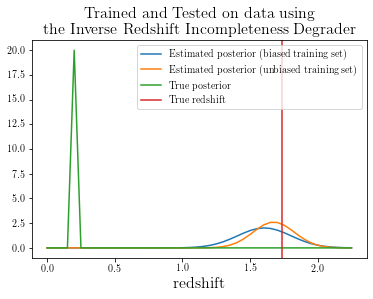

In [ ]:
chosen = 99
plt.plot(y_grid, cde_test_bias[chosen], label='Estimated posterior (biased training set)')
plt.plot(y_grid, cde_test[chosen], label='Estimated posterior (unbiased training set)')
plt.plot(grid, posteriors_test[chosen], label='True posterior')
plt.axvline(Y_samples[testing][chosen], 0, 1, c='C3', label='True redshift')
plt.legend()
plt.xlabel("redshift")
plt.title('Trained and Tested on data using \n the Inverse Redshift Incompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_cde_99.pdf", dpi=300, bbox_inches = "tight")
plt.show()

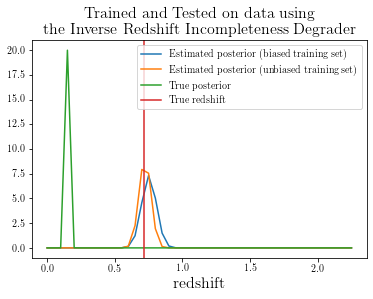

In [ ]:
chosen = 999
plt.plot(y_grid, cde_test_bias[chosen], label='Estimated posterior (biased training set)')
plt.plot(y_grid, cde_test[chosen], label='Estimated posterior (unbiased training set)')
plt.plot(grid, posteriors_test[chosen], label='True posterior')
plt.axvline(Y_samples[testing][chosen], 0, 1, c='C3', label='True redshift')
plt.legend()
plt.xlabel("redshift")
plt.title('Trained and Tested on data using \n the Inverse Redshift Incompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_cde_999_redshift.pdf", dpi=300, bbox_inches = "tight")
plt.show()

Galaxy 12539 has the highest KLD = 79.46514436991883


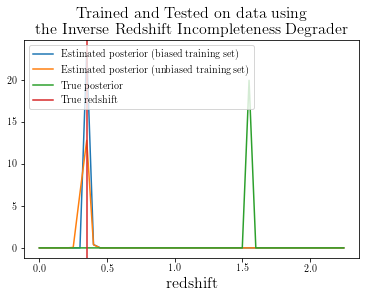

In [ ]:
#max KLD
gal_KLD_max = KLDs.argmax()
print(f'Galaxy {gal_KLD_max} has the highest KLD = {KLDs[gal_KLD_max]}')

plt.plot(y_grid, cde_test_bias[gal_KLD_max], label='Estimated posterior (biased training set)')
plt.plot(y_grid, cde_test[gal_KLD_max], label='Estimated posterior (unbiased training set)')
plt.plot(grid, posteriors_test[gal_KLD_max], label='True posterior')
plt.axvline(Y_samples[testing][gal_KLD_max], 0, 1, c='C3', label='True redshift')
plt.legend(loc='upper left')
plt.xlabel("redshift")
plt.title('Trained and Tested on data using \n the Inverse Redshift Incompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_cde_maxKLD.pdf", dpi=300, bbox_inches = "tight")
plt.show()

Galaxy 44120 has the lowest KLD = 1.264342050939596e-07


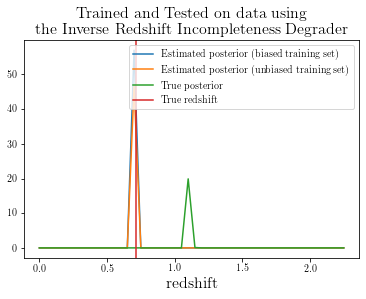

In [ ]:
#min KLD
gal_KLD_min = KLDs.argmin()
print(f'Galaxy {gal_KLD_min} has the lowest KLD = {KLDs[gal_KLD_min]}')

plt.plot(y_grid, cde_test_bias[gal_KLD_min], label='Estimated posterior (biased training set)')
plt.plot(y_grid, cde_test[gal_KLD_min], label='Estimated posterior (unbiased training set)')
plt.plot(grid, posteriors_test[gal_KLD_min], label='True posterior')
plt.axvline(Y_samples[testing][gal_KLD_min], 0, 1, c='C3', label='True redshift')
plt.legend(loc='upper right')
plt.xlabel("redshift")
plt.title('Trained and Tested on data using \n the Inverse Redshift Incompleteness Degrader')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_cde_minKLD.pdf", dpi=300, bbox_inches = "tight")
plt.show()

### Summary Statistics:
following [Demo: RAIL Evaluation](https://github.com/LSSTDESC/RAIL/blob/master/examples/evaluation/demo.ipynb)

Imports:



In [ ]:
from rail.evaluation.metrics.pit import *
from rail.evaluation.metrics.cdeloss import *
#from utils import read_pz_output, plot_pit_qq, ks_plot
#from main import Summary
import qp 
import os
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
from IPython.display import Markdown
import h5py
import os
from qp.ensemble import Ensemble
from qp import interp

In [ ]:
# ks_plot from utils
def ks_plot(pitobj, n_quant=100):
    """ KS test illustration.
    Ancillary function to be used by class KS."""
    #pits = ks._pits
    spl_ens, metamets = pitobj.evaluate()
    pits = np.array(pitobj._pit_samps)
    ksobj = PITKS(pits, spl_ens)
    stat_and_pval = ksobj.evaluate()
    xvals = np.linspace(0., 1., n_quant)
    yvals = np.array([np.histogram(pits, bins=len(xvals))[0]])
    pit_cdf = Ensemble(interp, data=dict(xvals=xvals, yvals=yvals)).cdf(xvals)[0]
    uniform_yvals = np.array([np.full(n_quant, 1.0 / float(n_quant))])
    uniform_cdf = Ensemble(interp, data=dict(xvals=xvals, yvals=uniform_yvals)).cdf(xvals)[0]

    plt.figure(figsize=[4, 4])
    plt.plot(xvals, uniform_cdf, 'r-', label="uniform")
    plt.plot(xvals, pit_cdf, 'b-', label="sample PIT")
    bin_stat = np.argmax(np.abs(pit_cdf - uniform_cdf))

    plt.vlines(x=xvals[bin_stat],
               ymin=np.min([pit_cdf[bin_stat], uniform_cdf[bin_stat]]),
               ymax=np.max([pit_cdf[bin_stat], uniform_cdf[bin_stat]]),
               colors='k')
    plt.plot(xvals[bin_stat], pit_cdf[bin_stat], "k.")
    plt.plot(xvals[bin_stat], uniform_cdf[bin_stat], "k.")
    ymean = (pit_cdf[bin_stat] + uniform_cdf[bin_stat]) / 2.
    plt.text(xvals[bin_stat] + 0.05, ymean, "max", fontsize=16)
    plt.xlabel("PIT value")
    plt.ylabel("CDF(PIT)")
    xtext = 0.63
    ytext = 0.03
    plt.text(xtext, ytext, f"KS={stat_and_pval.statistic:.4f}", fontsize=16)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()


In [ ]:
pitobj = PIT(Q, Y_samples[testing])
quant_ens, metamets = pitobj.evaluate()

pitobj_bias = PIT(Q_bias, Y_samples[testing])
quant_ens_bias, metamets_bias = pitobj_bias.evaluate()

/usr/local/lib/python3.7/dist-packages/rail/evaluation/metrics/pit.py:181: UserWarning: p-value floored: true value smaller than 0.001
  ad_results = stats.anderson_ksamp([pits_clean, uniform_yvals])


Kolmogorov-Smirnov (KS) Test for the representative data:

/usr/local/lib/python3.7/dist-packages/rail/evaluation/metrics/pit.py:181: UserWarning: p-value floored: true value smaller than 0.001
  ad_results = stats.anderson_ksamp([pits_clean, uniform_yvals])


KS metric of this sample: 0.0865


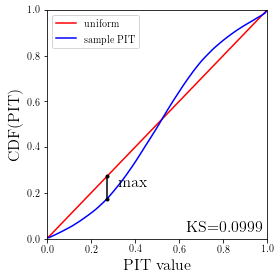

In [ ]:
#Summary statistics of CDF-based metrics

# Kolmogorov-Smirnov
ksobj = PITKS(pit_values, quant_ens)
ks_stat_and_pval = ksobj.evaluate()
ks_stat_and_pval
ks_plot(pitobj)
print(f"KS metric of this sample: {ks_stat_and_pval.statistic:.4f}")
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_ks_test.pdf", dpi=300, bbox_inches = "tight")


Kolmogorov-Smirnov (KS) Test for the biased data:

/usr/local/lib/python3.7/dist-packages/rail/evaluation/metrics/pit.py:181: UserWarning: p-value floored: true value smaller than 0.001
  ad_results = stats.anderson_ksamp([pits_clean, uniform_yvals])


KS metric of this sample: 0.0865


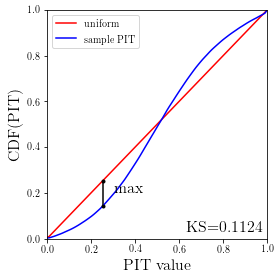

In [ ]:
# Kolmogorov-Smirnov bias
ksobj_bias = PITKS(pit_values, quant_ens_bias)
ks_stat_and_pval_bias = ksobj_bias.evaluate()
ks_stat_and_pval_bias
ks_plot(pitobj_bias)
print(f"KS metric of this sample: {ks_stat_and_pval_bias.statistic:.4f}")
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/z_pivot=1.38/z_pivot_1.38_ks_test_bias.pdf", dpi=300, bbox_inches = "tight")


Cramer-von Mises (CvM) Test for the representative data:

In [ ]:
# Cramer-von Mises
cvmobj = PITCvM(pit_values, quant_ens)
cvm_stat_and_pval = cvmobj.evaluate()

print(f"CvM metric of this sample: {cvm_stat_and_pval.statistic:.4f}")

CvM metric of this sample: 196.2525


Cramer-von Mises (CvM) Test for the biased data:

In [ ]:
# Cramer-von Mises bias
cvmobj_bias = PITCvM(pit_values_bias, quant_ens_bias)
cvm_stat_and_pval_bias = cvmobj_bias.evaluate()

print(f"CvM metric of this sample: {cvm_stat_and_pval_bias.statistic:.4f}")

CvM metric of this sample: 460.7476


Anderson-Darling (AD) Test for the representative data:

In [ ]:
# Anderson-Darling
adobj = PITAD(pit_values, quant_ens)
ad_stat_crit_sig = adobj.evaluate()
ad_stat_crit_sig

ad_stat_crit_sig

print(f"AD metric of this sample: {ad_stat_crit_sig.statistic:.4f}")

ad_stat_crit_sig_cut = adobj.evaluate(pit_min=0.01, pit_max=0.99)
print(f"AD metric of this sample: {ad_stat_crit_sig.statistic:.4f}") 
print(f"AD metric for 0.01 < PIT < 0.99: {ad_stat_crit_sig_cut.statistic:.4f}")

2358 PITs removed from the sample.
AD metric of this sample: 1348.1261
6827 PITs removed from the sample.
AD metric of this sample: 1348.1261
AD metric for 0.01 < PIT < 0.99: 280.5092


/usr/local/lib/python3.7/dist-packages/rail/evaluation/metrics/pit.py:181: UserWarning: p-value floored: true value smaller than 0.001
  ad_results = stats.anderson_ksamp([pits_clean, uniform_yvals])


Anderson-Darling (AD) Test for the biased data:

In [ ]:
# Anderson-Darling bias
adobj_bias = PITAD(pit_values_bias, quant_ens_bias)
ad_stat_crit_sig_bias = adobj_bias.evaluate()
ad_stat_crit_sig_bias

ad_stat_crit_sig_bias

print(f"AD metric of this sample: {ad_stat_crit_sig_bias.statistic:.4f}")

ad_stat_crit_sig_cut_bias = adobj_bias.evaluate(pit_min=0.01, pit_max=0.99)
print(f"AD metric of this sample: {ad_stat_crit_sig_bias.statistic:.4f}") 
print(f"AD metric for 0.01 < PIT < 0.99: {ad_stat_crit_sig_cut_bias.statistic:.4f}")

3603 PITs removed from the sample.
AD metric of this sample: 2821.9496
10719 PITs removed from the sample.
AD metric of this sample: 2821.9496
AD metric for 0.01 < PIT < 0.99: 464.6090


/usr/local/lib/python3.7/dist-packages/rail/evaluation/metrics/pit.py:181: UserWarning: p-value floored: true value smaller than 0.001
  ad_results = stats.anderson_ksamp([pits_clean, uniform_yvals])


### CDE Loss
CDE Loss for the representative data:

In [ ]:
# CDE Loss
cdelossobj = CDELoss(Q, y_grid, Y_samples[testing])

cde_stat_and_pval = cdelossobj.evaluate()
cde_stat_and_pval

print(f"CDE loss of this sample: {cde_stat_and_pval.statistic:.2f}")

CDE loss of this sample: -6.60


CDE Loss for the biased data:

In [ ]:
# CDE Loss bias
cdelossobj_bias = CDELoss(Q_bias, y_grid, Y_samples[testing])

cde_stat_and_pval_bias = cdelossobj_bias.evaluate()
cde_stat_and_pval_bias

print(f"CDE loss of this sample: {cde_stat_and_pval_bias.statistic:.2f}")

CDE loss of this sample: -7.80


### Summary of the statistical tests table:
(and comparison to the DC1 paper values)

In [ ]:
# Summary from main.py
from examples.evaluation.utils import *
from rail.evaluation.metrics.pit import *
from rail.evaluation.metrics.cdeloss import *
import time as t

class Summary:
    """ Summary tables with all metrics available. """
    def __init__(self, pdfs, xvals, ztrue):
        """Class constructor."""
        # placeholders for metrics to be calculated
        self._pdfs = pdfs
        self._xvals = xvals
        self._ztrue = ztrue
        self._pit_out_rate = None
        self._ks = None
        self._cvm = None
        self._ad = None
        self._cde_loss = None
        self._fzdata = qp.Ensemble(qp.interp, data=dict(xvals=xvals, yvals=pdfs))

    def evaluate_all(self, pitobj=None):
        if pitobj is None:
            pitobj = PIT(self._fzdata, self._ztrue)
        spl_ens, metamets = pitobj.evaluate()
        pit_vals = pitobj._pit_samps
        self._pit_out_rate = PITOutRate(pit_vals, spl_ens).evaluate()
        ksobj = PITKS(pit_vals, spl_ens)
        self._ks = ksobj.evaluate().statistic
        cvmobj = PITCvM(pit_vals, spl_ens)
        self._cvm = cvmobj.evaluate().statistic
        adobj = PITAD(pit_vals, spl_ens)
        self._ad = adobj.evaluate().statistic
        cdeobj = CDELoss(self._fzdata, self._xvals, self._ztrue)
        self._cde_loss = cdeobj.evaluate().statistic

    def markdown_metrics_table(self, show_dc1=None, pitobj=None):
        self.evaluate_all(pitobj=pitobj)
        if show_dc1:
            dc1 = DC1()
            if show_dc1 not in dc1.codes:
                raise ValueError(f"{show_dc1} not in the list of codes from DC1: {dc1.codes}" )
            table = str("Metric|Value|DC1 reference value \n ---|---:|---: \n ")
            table += f"PIT out rate | {self._pit_out_rate:11.4f} |{dc1.results['PIT out rate'][show_dc1]:11.4f} \n"
            table += f"KS           | {self._ks:11.4f}  |{dc1.results['KS'][show_dc1]:11.4f} \n"
            table += f"CvM          | {self._cvm:11.4f} |{dc1.results['CvM'][show_dc1]:11.4f} \n"
            table += f"AD           | {self._ad:11.4f}  |{dc1.results['AD'][show_dc1]:11.4f} \n"
            table += f"CDE loss     | {self._cde_loss:11.2f} |{dc1.results['CDE loss'][show_dc1]:11.2f} \n"
        else:
            table = "Metric|Value \n ---|---: \n "
            table += f"PIT out rate | {self._pit_out_rate:11.4f} \n"
            table += f"KS           | {self._ks:11.4f}  \n"
            table += f"CvM          | {self._cvm:11.4f} \n"
            table += f"AD           | {self._ad:11.4f}  \n"
            table += f"CDE loss     | {self._cde_loss:11.2f} \n"
        return Markdown(table)

    def print_metrics_table(self, pitobj=None):
        self.evaluate_all(pitobj=pitobj)
        table = str(
            "   Metric    |    Value \n" +
            "-------------|-------------\n" +
            f"PIT out rate | {self._pit_out_rate:11.4f}\n" +
            f"KS           | {self._ks:11.4f}\n" +
            f"CvM          | {self._cvm:11.4f}\n" +
            f"AD           | {self._ad:11.4f}\n" +
            f"CDE loss     | {self._cde_loss:11.4f}\n" )
        print(table)


In [ ]:
# Summary
summary = Summary(approx_pdf_on_grid, y_grid, Y_samples[testing])
summary.markdown_metrics_table(pitobj=pitobj) # pitobj as optional input to speed-up metrics evaluation

summary.markdown_metrics_table(pitobj=pitobj, show_dc1="FlexZBoost")

/usr/local/lib/python3.7/dist-packages/rail/evaluation/metrics/pit.py:181: UserWarning: p-value floored: true value smaller than 0.001
  ad_results = stats.anderson_ksamp([pits_clean, uniform_yvals])


Metric|Value|DC1 reference value 
 ---|---:|---: 
 PIT out rate |      0.0052 |     0.0202 
KS           |      0.0999  |     0.0240 
CvM          |    213.1161 |    68.8300 
AD           |    895.8669  |   478.8000 
CDE loss     |       -6.60 |     -10.60 


## Plots of the overall statistics for all z-pivots (for all degradations):
Plot of the KS statistics against z-pivot:

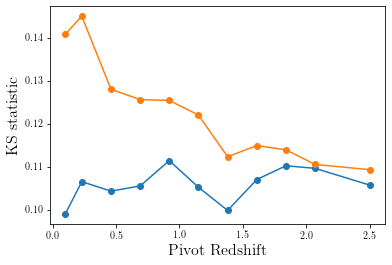

In [ ]:
# plot of all KS stats vs Z_pivot
ks_stats = [0.0991, 0.1066, 0.1044, 0.1056, 0.1115, 0.1053, 0.0999, 0.1071, 0.1103, 0.1097, 0.1058]

zs_pivot = [0.10, 0.23, 0.46, 0.69, 0.92, 1.15, 1.38, 1.61, 1.84, 2.07, 2.50]

ks_stats_bias = [0.1409, 0.1451, 0.1281, 0.1257, 0.1255, 0.1221, 0.1124, 0.1150, 0.1140, 0.1106, 0.1094]

plt.plot(zs_pivot, ks_stats, 'o-')
plt.plot(zs_pivot, ks_stats_bias, 'o-')
plt.xlabel('Pivot Redshift')
plt.ylabel('KS statistic')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/KS_metric_vs_z_pivot.pdf", dpi=300, bbox_inches = "tight")

Plot of the CvM statistics against z-pivot:

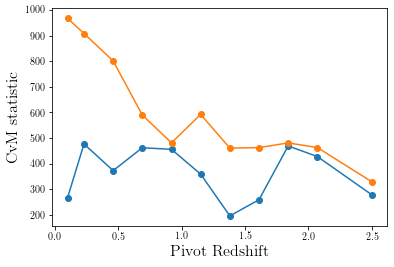

In [ ]:
# plot of all CvM stats vs Z_pivot
cvm_stats = [266.7089, 476.8774, 373.0453, 462.3420, 456.0688, 359.1967, 196.2525, 259.3535, 469.2638, 427.9421, 278.4575]

cvm_stats_bias = [967.9618, 908.2545, 801.1186, 589.9215, 481.4182, 592.5270, 460.7476, 462.7779, 481.2291, 463.1441, 329.3743]

zs_pivot = [0.10, 0.23, 0.46, 0.69, 0.92, 1.15, 1.38, 1.61, 1.84, 2.07, 2.50]

plt.plot(zs_pivot, cvm_stats, 'o-')
plt.plot(zs_pivot, cvm_stats_bias, 'o-')
plt.xlabel('Pivot Redshift')
plt.ylabel('CvM statistic')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/CvM_metric_vs_z_pivot.pdf", dpi=300, bbox_inches = "tight")

Plot of the AD statistics against z-pivot:

Text(0, 0.5, 'AD statistic')

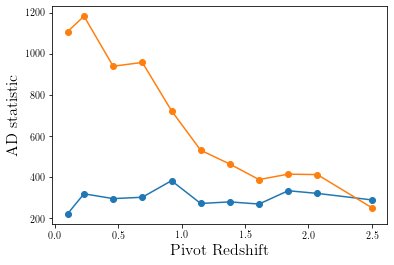

In [ ]:
#AD Satistics

AD_stats = [222.1050, 319.9702, 296.3611, 303.1162, 383.6567, 272.8522, 280.5092, 270.0181, 334.8004, 321.8775, 290.0814]

zs_pivot = [0.10, 0.23, 0.46, 0.69, 0.92, 1.15, 1.38, 1.61, 1.84, 2.07, 2.50]

AD_stats_bias = [1108.8409, 1184.2302, 940.7909, 959.2891, 724.2809, 531.9186, 464.6090, 389.1583, 415.4788, 413.4170, 252.1496]

plt.plot(zs_pivot, AD_stats, 'o-')
plt.plot(zs_pivot, AD_stats_bias, 'o-')
plt.xlabel('Pivot Redshift')
plt.ylabel('AD statistic')
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/AD_metric_vs_z_pivot.pdf", dpi=300, bbox_inches = "tight")

Plot of the CDE Loss against z-pivot:

0.5118432094639728


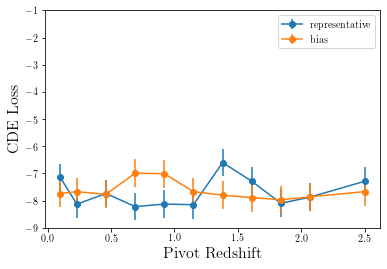

In [ ]:
# plot of all CDE Loss vs Z_pivot
cde_loss = [-7.15, -8.13, -7.74, -8.22, -8.13, -8.15, -6.60, -7.29, -8.10, -7.87, -7.29]
error = np.std(cde_loss)
print(error)

zs_pivot = [0.10, 0.23, 0.46, 0.69, 0.92, 1.15, 1.38, 1.61, 1.84, 2.07, 2.50]

cde_loss_bias = [-7.74, -7.67, -7.77, -6.99, -7.01, -7.67, -7.80, -7.89, -7.97, -7.86, -7.67]

plt.errorbar(zs_pivot, cde_loss, yerr=error, fmt = '-o', label="representative")
plt.errorbar(zs_pivot, cde_loss_bias, yerr=error,  fmt = '-o', label="bias")
plt.legend()
plt.xlabel('Pivot Redshift')
plt.ylabel('CDE Loss')
plt.ylim(-9, -1)
pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/CDE_loss_vs_z_pivot.pdf", dpi=300, bbox_inches = "tight")

Plot of all PIT Summary Statistics together:

0.003717592751737151
96.29226553329305
39.64587381940853


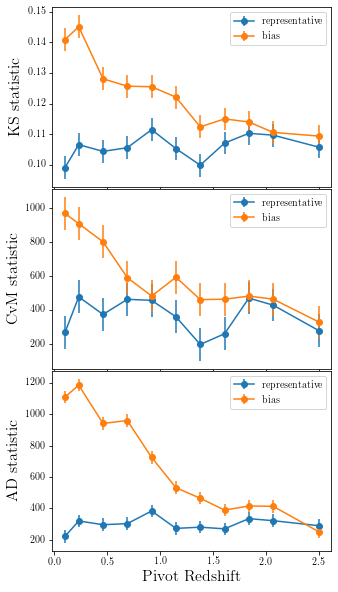

In [ ]:
# all PIT summary statistics

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(5, 10))

ks_stats = [0.0991, 0.1066, 0.1044, 0.1056, 0.1115, 0.1053, 0.0999, 0.1071, 0.1103, 0.1097, 0.1058]
error_ks = np.std(ks_stats)
print(error_ks)
zs_pivot = [0.10, 0.23, 0.46, 0.69, 0.92, 1.15, 1.38, 1.61, 1.84, 2.07, 2.50]
ks_stats_bias = [0.1409, 0.1451, 0.1281, 0.1257, 0.1255, 0.1221, 0.1124, 0.1150, 0.1140, 0.1106, 0.1094]


ax1.errorbar(zs_pivot, ks_stats, yerr=error_ks, fmt = '-o', label="representative")
ax1.errorbar(zs_pivot, ks_stats_bias, yerr=error_ks, fmt = '-o', label="bias")

#ax1.plot(np.unique(zs_pivot), np.poly1d(np.polyfit(zs_pivot, ks_stats, 1))(np.unique(zs_pivot)), color='grey', linestyle='dashed', label='best fit')
#ax1.plot(np.unique(zs_pivot), np.poly1d(np.polyfit(zs_pivot, ks_stats_bias, 1))(np.unique(zs_pivot)), color='grey', linestyle='dashed')

ax1.legend()
ax1.set_ylabel('KS statistic')
#ax1.set_ylim(0.08, 0.24)


#CvM
cvm_stats = [266.7089, 476.8774, 373.0453, 462.3420, 456.0688, 359.1967, 196.2525, 259.3535, 469.2638, 427.9421, 278.4575]
error_cvm = np.std(cvm_stats)
print(error_cvm)
cvm_stats_bias = [967.9618, 908.2545, 801.1186, 589.9215, 481.4182, 592.5270, 460.7476, 462.7779, 481.2291, 463.1441, 329.3743]
zs_pivot = [0.10, 0.23, 0.46, 0.69, 0.92, 1.15, 1.38, 1.61, 1.84, 2.07, 2.50]

ax2.errorbar(zs_pivot, cvm_stats, yerr=error_cvm, fmt = '-o', label="representative")
ax2.errorbar(zs_pivot, cvm_stats_bias, yerr=error_cvm, fmt = '-o', label="bias")

#ax2.plot(np.unique(zs_pivot), np.poly1d(np.polyfit(zs_pivot, cvm_stats, 1))(np.unique(zs_pivot)), color='grey', linestyle='dashed', label='best fit')
#ax2.plot(np.unique(zs_pivot), np.poly1d(np.polyfit(zs_pivot, cvm_stats_bias, 1))(np.unique(zs_pivot)), color='grey', linestyle='dashed')

ax2.legend()
ax2.set_ylabel('CvM statistic')
#ax2.set_ylim(70, 1250)




AD_stats = [222.1050, 319.9702, 296.3611, 303.1162, 383.6567, 272.8522, 280.5092, 270.0181, 334.8004, 321.8775, 290.0814]
error_ad = np.std(AD_stats)
print(error_ad)
zs_pivot = [0.10, 0.23, 0.46, 0.69, 0.92, 1.15, 1.38, 1.61, 1.84, 2.07, 2.50]
AD_stats_bias = [1108.8409, 1184.2302, 940.7909, 959.2891, 724.2809, 531.9186, 464.6090, 389.1583, 415.4788, 413.4170, 252.1496]

ax3.errorbar(zs_pivot, AD_stats, yerr=error_ad, fmt = '-o', label="representative")
ax3.errorbar(zs_pivot, AD_stats_bias, yerr=error_ad, fmt = '-o', label="bias")

#ax3.plot(np.unique(zs_pivot), np.poly1d(np.polyfit(zs_pivot, AD_stats, 1))(np.unique(zs_pivot)), color='grey', linestyle='dashed', label='best fit')
#ax3.plot(np.unique(zs_pivot), np.poly1d(np.polyfit(zs_pivot, AD_stats_bias, 1))(np.unique(zs_pivot)), color='grey', linestyle='dashed')

ax3.legend()
ax3.set_xlabel('Pivot Redshift')
ax3.set_ylabel('AD statistic')
#ax3.set_ylim(500, 6000)

plt.subplots_adjust(hspace=.01)

pb.savefig("/content/drive/MyDrive/Coding/Results/InvRedshiftIncompleteness_degradation+photo-z+metrics/PIT_Summary_Statistics_vs_z_pivot.pdf", dpi=300, bbox_inches = "tight")